<a href="https://colab.research.google.com/github/pathdata/LearningCurve/blob/master/COMP0188_Week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents

This notebook has 4 parts.

1. Part I, Preparation: load the CIFAR-10 dataset.
2. Part II, Keras Model API: We will use `tf.keras.Model` to define arbitrary neural network architecture.
3. Part III, Keras Sequential + Functional API: We will use `tf.keras.Sequential` to define a linear feed-forward network very conveniently, and then explore the functional libraries for building unique and uncommon models that require more flexibility.
4. Part IV, CIFAR-10 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features.

# GPU

You can manually switch to a GPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. You should do this before running the following cells to import packages, since the kernel gets restarted upon switching runtimes.

In [ ]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

%matplotlib inline

USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models.
print_every = 100
print('Using device: ', device)

Using device:  /device:GPU:0


# Part I: Preparation

First, we load the CIFAR-10 dataset. This might take a few minutes to download the first time you run it, but after that the files should be cached on disk and loading should be faster.

The `tf.keras.datasets` package in TensorFlow provides prebuilt utility functions for loading many common datasets.

For the purposes of this assignment we will still write our own code to preprocess the data and iterate through it in minibatches. The `tf.data` package in TensorFlow provides tools for automating this process, but working with this package adds extra complication and is beyond the scope of this notebook. However using `tf.data` can be much more efficient than the simple approach used in this notebook.

In [ ]:
def load_cifar10_without_scaling(num_training=45000, num_validation=5000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    print(mask)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10_without_scaling()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170498071/170498071 [==============================] - 4s 0us/step
range(45000, 50000)
Train data shape:  (45000, 32, 32, 3)
Train labels shape:  (45000,) int32
Validation data shape:  (5000, 32, 32, 3)
Validation labels shape:  (5000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


[6 9 9 4 1 1 2 7 8 3]
255.0 0.0


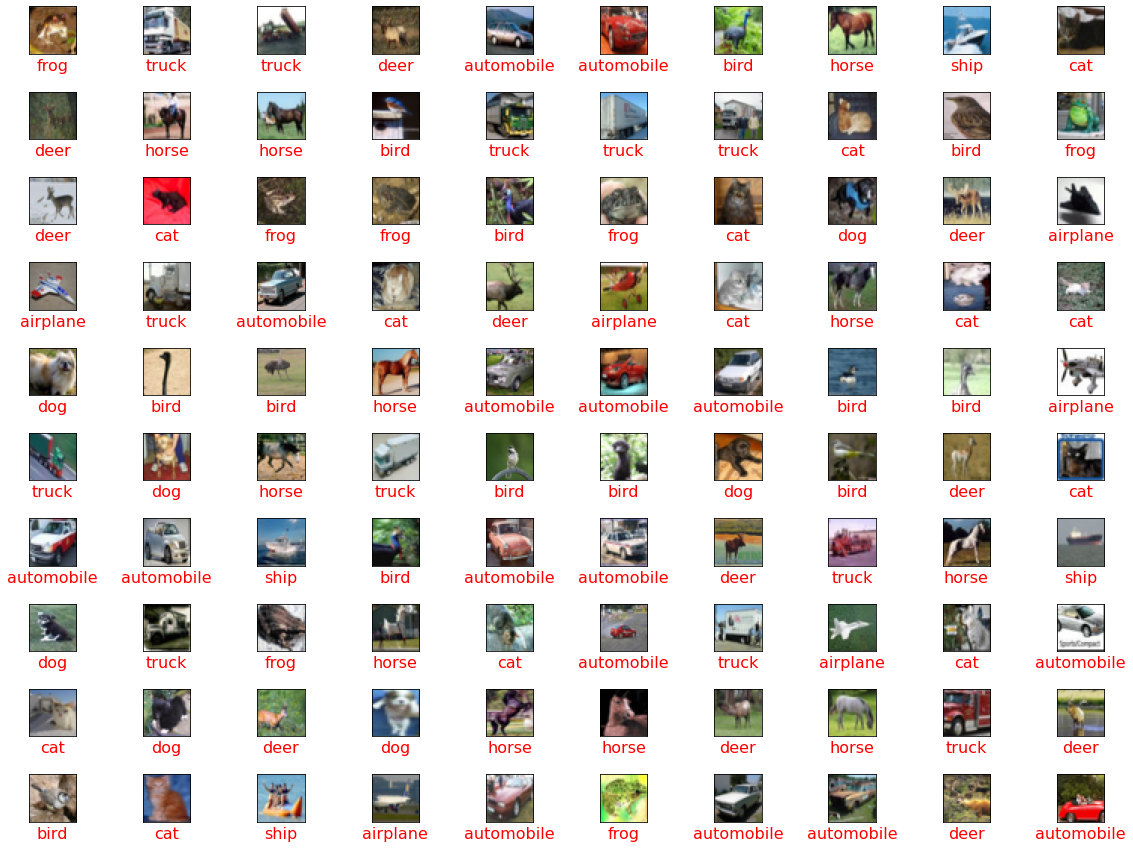

In [ ]:
# Visualise a subset of images
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings(action='ignore', category=DeprecationWarning, module='matplotlib')
warnings.filterwarnings(action='ignore')

labelNames=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def plot_cifar_images(images,class_label):
    fig,axes=plt.subplots(10,10,figsize=(20,15))
    fig.subplots_adjust(hspace=0.8,wspace=0.3)

    for i,ax in enumerate(axes.flat):
        ax.imshow(X_train[i]/255)
        xlab=labelNames[int(class_label[i])]
        ax.set_xlabel(xlab,fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.label.set_color('red')

#Visualize the training images
images=X_train[0:100]
cls=y_train[0:100]
# Visualize the subset of 10 labels of ytrain
print(y_train[0:10])
#
print(np.max(X_train[0]), np.min(X_train[0]))
plot_cifar_images(images, cls)

In [ ]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    print(mask)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170498071/170498071 [==============================] - 4s 0us/step
range(49000, 50000)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


[6 9 9 4 1 1 2 7 8 3]
2.0946307 -1.9888586


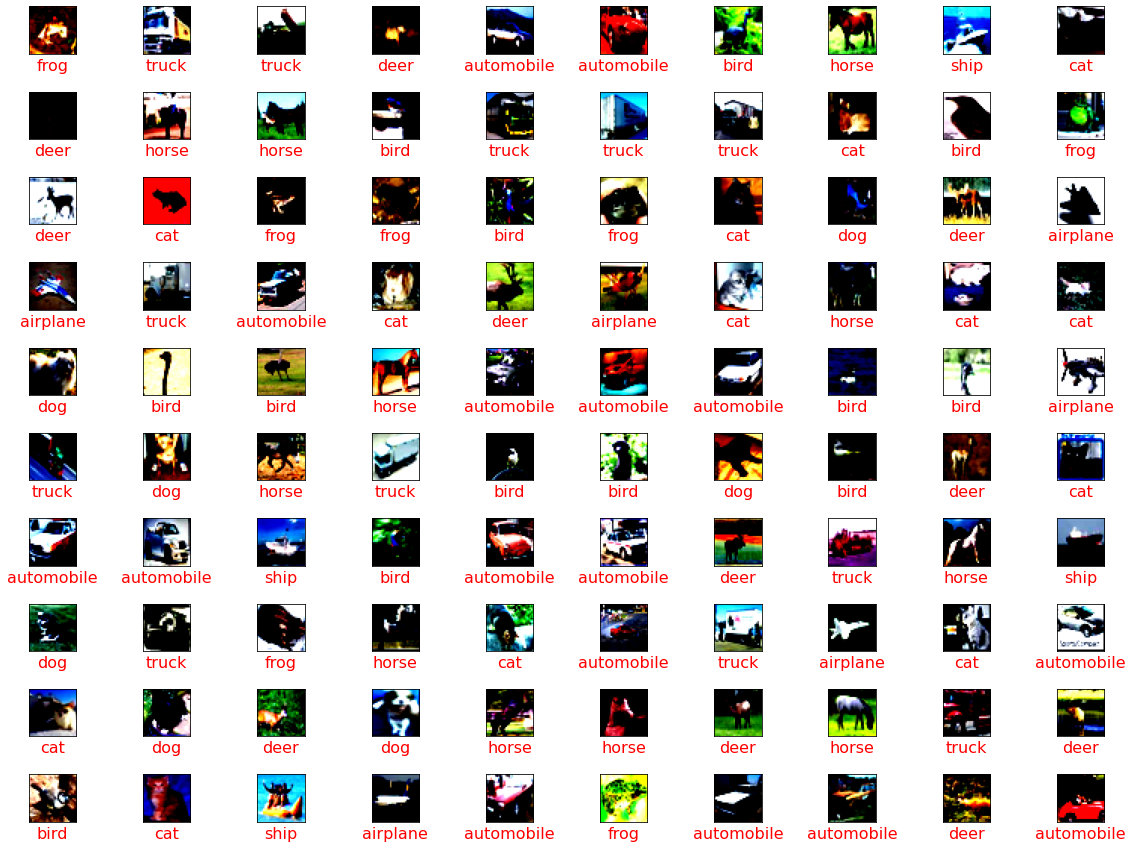

In [ ]:
# Visualise a subset of images
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings(action='ignore', category=DeprecationWarning, module='matplotlib')
warnings.filterwarnings(action='ignore')

labelNames=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

def plot_cifar_images(images,class_label):
    fig,axes=plt.subplots(10,10,figsize=(20,15))
    fig.subplots_adjust(hspace=0.8,wspace=0.3)

    for i,ax in enumerate(axes.flat):
        ax.imshow(X_train[i])
        xlab=labelNames[int(class_label[i])]
        ax.set_xlabel(xlab,fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.label.set_color('red')

#Visualize the training images
images=X_train[0:100]
cls=y_train[0:100]
# Visualize the subset of 10 labels of ytrain
print(y_train[0:10])
#
print(np.max(X_train[0]), np.min(X_train[0]))
plot_cifar_images(images,cls)

In [ ]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y

        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

In [ ]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 10: break

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)
7 (64, 32, 32, 3) (64,)
8 (64, 32, 32, 3) (64,)
9 (64, 32, 32, 3) (64,)
10 (64, 32, 32, 3) (64,)
11 (64, 32, 32, 3) (64,)


# Part II: Keras Model Subclassing API

TensorFlow 2.0 provides higher-level APIs such as `tf.keras` which make it easy to build models out of modular, object-oriented layers. Further, TensorFlow 2.0 uses eager execution that evaluates operations immediately, without explicitly constructing any computational graphs. This makes it easy to write and debug models, and reduces the boilerplate code.

In this part of the notebook we will define neural network models using the `tf.keras.Model` API. To implement your own model, you need to do the following:

1. Define a new class which subclasses `tf.keras.Model`. Give your class an intuitive name that describes it, like `TwoLayerFC` or `ThreeLayerConvNet`.
2. In the initializer `__init__()` for your new class, define all the layers you need as class attributes. The `tf.keras.layers` package provides many common neural-network layers, like `tf.keras.layers.Dense` for fully-connected layers and `tf.keras.layers.Conv2D` for convolutional layers. **Warning**: Don't forget to call `super(YourModelName, self).__init__()` as the first line in your initializer!
3. Implement the `call()` method for your class; this implements the forward pass of your model, and defines the *connectivity* of your network. Layers defined in `__init__()` implement `__call__()` so they can be used as function objects that transform input Tensors into output Tensors. Don't define any new layers in `call()`; any layers you want to use in the forward pass should be defined in `__init__()`.

After you define your `tf.keras.Model` subclass, you can instantiate it and use it like the model functions from Part II.

### Keras Model Subclassing API: Two-Layer Network

Here is a concrete example of using the `tf.keras.Model` API to define a two-layer network. There are a few new bits of API to be aware of here:

We use an `Initializer` object to set up the initial values of the learnable parameters of the layers; in particular `tf.initializers.VarianceScaling`. You can read more about it here: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/initializers/VarianceScaling

We construct `tf.keras.layers.Dense` objects to represent the two fully-connected layers of the model. In addition to multiplying their input by a weight matrix and adding a bias vector, these layer can also apply a nonlinearity for you. For the first layer we specify a ReLU activation function by passing `activation='relu'` to the constructor; the second layer uses softmax activation function. Finally, we use `tf.keras.layers.Flatten` to flatten the output from the previous fully-connected layer.

In [ ]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super(TwoLayerFC, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu',
                                   kernel_initializer=initializer)
        self.fc2 = tf.keras.layers.Dense(num_classes, activation='softmax',
                                   kernel_initializer=initializer)
        self.flatten = tf.keras.layers.Flatten()

    def call(self, x, training=False):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def test_TwoLayerFC():
    """ A small unit test to exercise the TwoLayerFC model above. """
    input_size, hidden_size, num_classes = 50, 42, 10
    x = tf.zeros((64, input_size))
    model = TwoLayerFC(hidden_size, num_classes)
    with tf.device(device):
        scores = model(x)
        print(scores.shape)

test_TwoLayerFC()

(64, 10)


### Exercise 1: Keras Model Subclassing API: Three-Layer ConvNet
Now it's your turn to implement a three-layer ConvNet using the `tf.keras.Model` API. Your model should have the following architecture:

1. Convolutional layer with 5 x 5 kernels, with zero-padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 3 x 3 kernels, with zero-padding of 1
4. ReLU nonlinearity
5. Fully-connected layer to give class scores
6. Softmax nonlinearity

The number of channels (filters) in the convolutional layers will be provided as arguments in the function.

You should initialize the weights of your network using the same initialization method as was used in the two-layer network above.

**Hint**: Refer to the documentation for `tf.keras.layers.Conv2D` and `tf.keras.layers.Dense`:

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2D

https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dense

In [ ]:
class ThreeLayerConvNet(tf.keras.Model):
    def __init__(self, channel_1, channel_2, num_classes):
        super(ThreeLayerConvNet, self).__init__()
        ########################################################################
        # TODO: Implement the __init__ method for a three-layer ConvNet. You   #
        # should instantiate layer objects to be used in the forward pass.     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv1 = tf.keras.layers.Conv2D(channel_1, kernel_size=5, padding='same', activation = 'relu')
        self.conv2 = tf.keras.layers.Conv2D(channel_2, kernel_size=3, padding='same', activation = 'relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(num_classes, activation='softmax')
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################

    def call(self, x, training=False):
        scores = None
        ########################################################################
        # TODO: Implement the forward pass for a three-layer ConvNet. You      #
        # should use the layer objects defined in the __init__ method.         #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        scores = self.fc1(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################
        return scores

Once you complete the implementation of the `ThreeLayerConvNet` above you can run the following to ensure that your implementation does not crash and produces outputs of the expected shape.

In [ ]:
def test_ThreeLayerConvNet():
    channel_1, channel_2, num_classes = 12, 8, 10
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    with tf.device(device):
        x = tf.zeros((64, 3, 32, 32))
        scores = model(x)
        print(scores.shape)

test_ThreeLayerConvNet()

(64, 10)


### Keras Model Subclassing API: Eager Training

While keras models have a builtin training loop (using the `model.fit`), sometimes you need more customization. Here's an example, of a training loop implemented with eager execution.

In particular, notice `tf.GradientTape`. Automatic differentiation is used in the backend for implementing backpropagation in frameworks like TensorFlow. During eager execution, `tf.GradientTape` is used to trace operations for computing gradients later. A particular `tf.GradientTape` can only compute one gradient; subsequent calls to tape will throw a runtime error.

TensorFlow 2.0 ships with easy-to-use built-in metrics under `tf.keras.metrics` module. Each metric is an object, and we can use `update_state()` to add observations and `reset_state()` to clear all observations. We can get the current result of a metric by calling `result()` on the metric object.

In [ ]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1, is_training=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.

    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for

    Returns: Nothing, but prints progress during training
    """
    with tf.device(device):

        # Compute the loss like we did in Part II
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

        model = model_init_fn()
        optimizer = optimizer_init_fn()

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

        t = 0
        for epoch in range(num_epochs):

            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_accuracy.reset_states()

            for x_np, y_np in train_dset:
                with tf.GradientTape() as tape:

                    # Use the model function to build the forward pass.
                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)

                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                    # Update the metrics
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)

                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)

                        template = 'Iteration {}, Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result()*100,
                                             val_loss.result(),
                                             val_accuracy.result()*100))
                    t += 1

### Keras Model Subclassing API: Train a Two-Layer Network
We can now use the tools defined above to train a two-layer network on CIFAR-10. We define the `model_init_fn` and `optimizer_init_fn` that construct the model and optimizer respectively when called. Here we want to train the model using stochastic gradient descent with no momentum, so we construct a `tf.keras.optimizers.SGD` function; you can [read about it here](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/optimizers/SGD).

You don't need to tune any hyperparameters here, but you should achieve validation accuracies above 40% after one epoch of training.

In [ ]:
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn():
    return TwoLayerFC(hidden_size, num_classes)

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.171018600463867, Accuracy: 14.0625, Val Loss: 2.8611159324645996, Val Accuracy: 13.500000953674316
Iteration 100, Epoch 1, Loss: 2.2596123218536377, Accuracy: 28.248764038085938, Val Loss: 1.9116322994232178, Val Accuracy: 36.70000076293945
Iteration 200, Epoch 1, Loss: 2.0874581336975098, Accuracy: 32.08177947998047, Val Loss: 1.8584147691726685, Val Accuracy: 39.599998474121094
Iteration 300, Epoch 1, Loss: 2.011039972305298, Accuracy: 33.710548400878906, Val Loss: 1.8458038568496704, Val Accuracy: 38.400001525878906
Iteration 400, Epoch 1, Loss: 1.9377529621124268, Accuracy: 35.7855339050293, Val Loss: 1.6916701793670654, Val Accuracy: 43.20000076293945
Iteration 500, Epoch 1, Loss: 1.891400694847107, Accuracy: 36.87936782836914, Val Loss: 1.6414588689804077, Val Accuracy: 44.10000228881836
Iteration 600, Epoch 1, Loss: 1.8612173795700073, Accuracy: 37.73658752441406, Val Loss: 1.6675105094909668, Val Accuracy: 42.599998474121094
Iteration 700, Epoch 1,

### Exercise 2: Keras Model Subclassing  API: Train a Three-Layer ConvNet
Here you should use the tools we've defined above to train a three-layer ConvNet on CIFAR-10. Your ConvNet should use 32 filters in the first convolutional layer and 16 filters in the second layer.

To train the model you should use gradient descent with momentum 0.9.  

**HINT**: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/optimizers/SGD

You don't need to perform any hyperparameter tuning, but you should achieve validation accuracies above 50% after training for one epoch.

In [ ]:
learning_rate = 3e-3
channel_1, channel_2, num_classes = 32, 16, 10

def model_init_fn():
    model = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return model

def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.9)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.395556926727295, Accuracy: 12.5, Val Loss: 2.334402084350586, Val Accuracy: 10.100000381469727
Iteration 100, Epoch 1, Loss: 1.9580274820327759, Accuracy: 30.368194580078125, Val Loss: 1.7346101999282837, Val Accuracy: 39.89999771118164
Iteration 200, Epoch 1, Loss: 1.8071566820144653, Accuracy: 35.743160247802734, Val Loss: 1.508171796798706, Val Accuracy: 46.0
Iteration 300, Epoch 1, Loss: 1.713317632675171, Accuracy: 39.124794006347656, Val Loss: 1.445911169052124, Val Accuracy: 49.79999923706055
Iteration 400, Epoch 1, Loss: 1.640156865119934, Accuracy: 41.75888442993164, Val Loss: 1.3957695960998535, Val Accuracy: 50.900001525878906
Iteration 500, Epoch 1, Loss: 1.589643955230713, Accuracy: 43.506736755371094, Val Loss: 1.3591945171356201, Val Accuracy: 52.10000228881836
Iteration 600, Epoch 1, Loss: 1.5601365566253662, Accuracy: 44.57414627075195, Val Loss: 1.346218228340149, Val Accuracy: 51.20000076293945
Iteration 700, Epoch 1, Loss: 1.53400874137

# Part III: Keras Sequential API
In Part II we introduced the `tf.keras.Model` API, which allows you to define models with any number of learnable layers and with arbitrary connectivity between layers.
However for many models you don't need such flexibility - a lot of models can be expressed as a sequential stack of layers, with the output of each layer fed to the next layer as input. If your model fits this pattern, then there is an even easier way to define your model: using `tf.keras.Sequential`. You don't need to write any custom classes; you simply call the `tf.keras.Sequential` constructor with a list containing a sequence of layer objects.

One complication with `tf.keras.Sequential` is that you must define the shape of the input to the model by passing a value to the `input_shape` of the first layer in your model.

### Keras Sequential API: Two-Layer Network
In this subsection, we will rewrite the two-layer fully-connected network using `tf.keras.Sequential`, and train it using the training loop defined above.

You don't need to perform any hyperparameter tuning here, but you should see validation accuracies above 40% after training for one epoch.

In [ ]:
learning_rate = 1e-2

def model_init_fn():
    input_shape = (32, 32, 3)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model

def optimizer_init_fn():
    return tf.keras.optimizers.SGD(learning_rate=learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 3.4844818115234375, Accuracy: 4.6875, Val Loss: 3.329542636871338, Val Accuracy: 12.399999618530273
Iteration 100, Epoch 1, Loss: 2.2183220386505127, Accuracy: 28.650989532470703, Val Loss: 1.9013257026672363, Val Accuracy: 37.099998474121094
Iteration 200, Epoch 1, Loss: 2.0589258670806885, Accuracy: 32.664798736572266, Val Loss: 1.8824049234390259, Val Accuracy: 38.400001525878906
Iteration 300, Epoch 1, Loss: 1.9881731271743774, Accuracy: 34.484012603759766, Val Loss: 1.8566466569900513, Val Accuracy: 37.20000076293945
Iteration 400, Epoch 1, Loss: 1.9242430925369263, Accuracy: 36.02711868286133, Val Loss: 1.7192631959915161, Val Accuracy: 41.20000076293945
Iteration 500, Epoch 1, Loss: 1.8821059465408325, Accuracy: 37.041542053222656, Val Loss: 1.65102219581604, Val Accuracy: 42.69999694824219
Iteration 600, Epoch 1, Loss: 1.8525359630584717, Accuracy: 37.949771881103516, Val Loss: 1.6807152032852173, Val Accuracy: 42.69999694824219
Iteration 700, Epoch 

### Abstracting Away the Training Loop
In the previous examples, we used a customised training loop to train models (e.g. `train_part34`). Writing your own training loop is only required if you need more flexibility and control during training your model. Alternately, you can also use  built-in APIs like `tf.keras.Model.fit()` and `tf.keras.Model.evaluate` to train and evaluate a model. Also remember to configure your model for training by calling `tf.keras.Model.compile.

You don't need to perform any hyperparameter tuning here, but you should see validation and test accuracies above 42% after training for one epoch.

In [ ]:
model = model_init_fn()
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.7361 - sparse_categorical_accuracy: 0.4209


[1.7360507249832153, 0.42089998722076416]

### Exercise 3: Keras Sequential API: Three-Layer ConvNet
Here you should use `tf.keras.Sequential` to reimplement the same three-layer ConvNet architecture used in Part II and Part III. As a reminder, your model should have the following architecture:

1. Convolutional layer with 32 5x5 kernels, using zero padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 16 3x3 kernels, using zero padding of 1
4. ReLU nonlinearity
5. Fully-connected layer giving class scores
6. Softmax nonlinearity

You should initialize the weights of the model using a `tf.initializers.VarianceScaling` as above.

You should train the model using SGD with momentum 0.9.

You don't need to perform any hyperparameter search, but you should achieve accuracy above 45% after training for one epoch.

In [ ]:
def model_init_fn():
    model = None
    ############################################################################
    # TODO: Construct a three-layer ConvNet using tf.keras.Sequential.         #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    channel_1, channel_2, num_classes = 32, 16, 10
    initializer = tf.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Conv2D(channel_1, kernel_size=5, padding='same', activation = 'relu', kernel_initializer=initializer),
        tf.keras.layers.Conv2D(channel_2, kernel_size=3, padding='same', activation = 'relu', kernel_initializer=initializer),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ]
    model = tf.keras.Sequential(layers)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return model

learning_rate = 5e-4
def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.9)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Iteration 0, Epoch 1, Loss: 2.815809488296509, Accuracy: 17.1875, Val Loss: 2.9318125247955322, Val Accuracy: 10.699999809265137
Iteration 100, Epoch 1, Loss: 2.0838801860809326, Accuracy: 28.109529495239258, Val Loss: 1.8354986906051636, Val Accuracy: 36.79999923706055
Iteration 200, Epoch 1, Loss: 1.9403066635131836, Accuracy: 32.276119232177734, Val Loss: 1.7210384607315063, Val Accuracy: 40.400001525878906
Iteration 300, Epoch 1, Loss: 1.8655600547790527, Accuracy: 34.727989196777344, Val Loss: 1.6539019346237183, Val Accuracy: 43.29999923706055
Iteration 400, Epoch 1, Loss: 1.800774097442627, Accuracy: 36.83369827270508, Val Loss: 1.6009315252304077, Val Accuracy: 45.400001525878906
Iteration 500, Epoch 1, Loss: 1.7556233406066895, Accuracy: 38.17677307128906, Val Loss: 1.5443097352981567, Val Accuracy: 45.29999923706055
Iteration 600, Epoch 1, Loss: 1.7235586643218994, Accuracy: 39.332881927490234, Val Loss: 1.5454761981964111, Val Accuracy: 45.10000228881836
Iteration 700, Epoch

We will also train this model with the built-in training loop APIs provided by TensorFlow.

In [ ]:
model = model_init_fn()
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.3521 - sparse_categorical_accuracy: 0.5220


[1.3521332740783691, 0.5220000147819519]

In [ ]:
model = model_init_fn()
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

Epoch 1/10
766/766 [==============================] - 4s 5ms/step - loss: 1.5832 - sparse_categorical_accuracy: 0.4442 - val_loss: 1.4225 - val_sparse_categorical_accuracy: 0.5040
Epoch 2/10
766/766 [==============================] - 3s 5ms/step - loss: 1.2304 - sparse_categorical_accuracy: 0.5692 - val_loss: 1.2103 - val_sparse_categorical_accuracy: 0.5740
Epoch 3/10
766/766 [==============================] - 3s 4ms/step - loss: 1.0877 - sparse_categorical_accuracy: 0.6231 - val_loss: 1.1484 - val_sparse_categorical_accuracy: 0.5790
Epoch 4/10
766/766 [==============================] - 3s 4ms/step - loss: 0.9870 - sparse_categorical_accuracy: 0.6601 - val_loss: 1.1455 - val_sparse_categorical_accuracy: 0.6030
Epoch 5/10
766/766 [==============================] - 3s 5ms/step - loss: 0.9153 - sparse_categorical_accuracy: 0.6840 - val_loss: 1.1032 - val_sparse_categorical_accuracy: 0.6140
Epoch 6/10
766/766 [==============================] - 4s 5ms/step - loss: 0.8520 - sparse_categorica

[1.1376848220825195, 0.6186000108718872]

# Part IV: CIFAR-10 open-ended challenge

In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with architectures, hyperparameters, loss functions, regularization, or anything else you can think of to train a model that achieves **at least 70%** accuracy on the **validation** set within 10 epochs. You can use the built-in train function, the `train_part34` function from above, or implement your own training loop.

Describe what you did at the end of the notebook.

### Some things you can try:
- **Filter size**: Above we used 5x5 and 3x3; is this optimal?
- **Number of filters**: Above we used 16 and 32 filters. Would more or fewer do better?
- **Pooling**: We didn't use any pooling above. Would this improve the model?
- **Normalization**: Would your model be improved with batch normalization, layer normalization, group normalization, or some other normalization strategy?
- **Network architecture**: The ConvNet above has only three layers of trainable parameters. Would a deeper model do better?
- **Global average pooling**: Instead of flattening after the final convolutional layer, would global average pooling do better? This strategy is used for example in Google's Inception network and in Residual Networks.
- **Regularization**: Would some kind of regularization improve performance? Maybe weight decay or dropout?

### NOTE: Batch Normalization / Dropout
If you are using Batch Normalization and Dropout, remember to pass `is_training=True` if you use the `train_part34()` function. BatchNorm and Dropout layers have different behaviors at training and inference time. `training` is a specific keyword argument reserved for this purpose in any `tf.keras.Model`'s `call()` function. Read more about this here : https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization#methods
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dropout#methods

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
  
### Have fun and happy training!

In [ ]:
class CustomConvNet(tf.keras.Model):
    def __init__(self):
        super(CustomConvNet, self).__init__()
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        pass

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################

    def call(self, input_tensor, training=False):
        ############################################################################
        # TODO: Construct a model that performs well on CIFAR-10                   #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        pass

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                            END OF YOUR CODE                              #
        ############################################################################
        return x


print_every = 700
num_epochs = 10

model = CustomConvNet()

def model_init_fn():
    return CustomConvNet()

def optimizer_init_fn():
    learning_rate = 1e-3
    return tf.keras.optimizers.Adam(learning_rate)

train_part34(model_init_fn, optimizer_init_fn, num_epochs=num_epochs, is_training=True)

## Describe what you did

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

**Answer:**

